# Text Analytics: 3rd Assignment (Part 2: Exercise 2)
## MSc in Data Science (2023/2024)

In [1]:
import tasks.preprocessing, tasks.models, tasks.tuning, tasks.util

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os

2024-02-27 14:22:43.517941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 14:22:43.517973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 14:22:43.520222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 14:22:43.533222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 14:22:45.459258: W tensorflow/compiler/tf2

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

INPUT_DIR = "input"
INPUT_MODEL_PATH = os.path.join(INPUT_DIR, "models")
OUTPUT_DIR = "output"
INTERMEDIATE_DIR = "intermediate"

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print("Executing with ", gpus[0].name if len(gpus) != 0 else "CPU")

Executing with  /physical_device:GPU:0


2024-02-27 14:22:48.508034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 14:22:48.592829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 14:22:48.593128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Dataset

Acquiring and preprocessing our data with the goal of eventually acquiring a sufficient representation of our text is the most difficult and time-consuming task. We thus split it in distinct phases:

* Original dataset acquisition and parsing
* Qualitative analysis and preprocessing
* Transformation for the NLP task

Note that due to the relative custom code complexity, most of the code used in this section was developed and imported from python source files located in the `tasks` module. In-depth documentation and implementation details can be found in these files. 

In [4]:
print("Loading training dataset...")
train_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-train.conllu"
)
print("Loading validation dataset...")
val_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-dev.conllu"
)
print("Loading test dataset...")
test_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-test.conllu"
)

print(
    f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}"
    "\nTest data shape: {test_df.shape}"
)

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2001 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2077 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (25511, 3)
Test data shape: {test_df.shape}


Below we can see a preview of our parsed training dataset. Our preprocessing exploits pandas's ordering scheme in order to make sure the words are inserted in the order they appear in the sentence. This ordering will prove important later.

In [5]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


As mentioned above, our dataset features words connected with punctuation such as "don't". These are normally treated as two words, with the first being their intuitive POS tag ("do" - AUX) and the second as part of the first ("n't" - PART).

This dataset contains both the full words and their split versions, with only the latter featuring valid POS tags. The former are instead marked by a pseudo-tag (here "_").

In [6]:
invalid_idx = train_df.pos == "_"
train_df[invalid_idx]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
704,won't,_,weblog-juancole.com_juancole_20051126063000_EN...
868,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1058,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1078,doesn't,_,weblog-blogspot.com_healingiraq_20040409053012...
...,...,...,...
207078,couldn't,_,reviews-319816-0025
207091,don't,_,reviews-319816-0025
207096,employees',_,reviews-319816-0025
207164,i'm,_,reviews-319816-0027


In [7]:
" ".join(train_df[invalid_idx].words.unique()[:30])

"don't won't doesn't haven't didn't others it's elena's women's children's i'm people's musharraf's sharon's hamas's right's cannot isn't one's let's reporter's he's that's pakistan's world's bush's military's sharif's can't couldn't"

Below we can see an example of a word being contained both times in the dataset, one in full with the pseudo-tag, and the other as split words with valid POS tags.

In [8]:
train_df.iloc[176:179]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
177,do,AUX,weblog-juancole.com_juancole_20051126063000_EN...
178,n't,PART,weblog-juancole.com_juancole_20051126063000_EN...


We thus remove the full words including the pseudo-tag from our datasets, ensuring that all target POS tags will be compliant with the UPOS scheme.

In [9]:
train_df = train_df[~invalid_idx]
val_df = val_df[val_df.pos != "_"]
test_df = test_df[test_df.pos != "_"]

### Qualitative Analysis

We analyze our dataset in two granualities: sentences and individual words. We begin by analyzing how many words are in each sentence, which will give us an idea on the size of context available for each word.

In [10]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words


train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

Figured saved to output/ex_2_dataset_stats.png


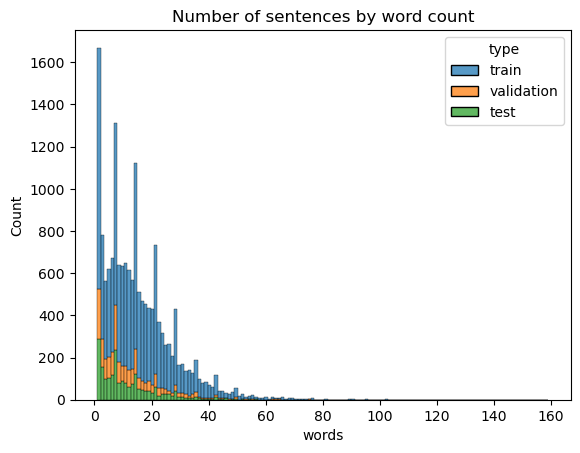

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
tasks.util.save_plot("ex_2_dataset_stats.png", OUTPUT_DIR)
plt.show()

As we can see from the graph above, there is a sizable portion of our sentences that feature very few words. In order to make the RNN training more efficient, we choose to discard sentences with very few words.

In [12]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [13]:
MIN_SENTENCE_LENGTH = 5

train_df = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

In [14]:
train_length.describe()

count    10539.000000
mean        18.967170
std         11.782365
min          5.000000
25%         10.000000
50%         16.000000
75%         24.000000
max        159.000000
Name: words, dtype: float64

In [15]:
val_length.describe()

count    1538.000000
mean       15.607932
std        10.050704
min         5.000000
25%         8.000000
50%        13.000000
75%        20.000000
max        75.000000
Name: words, dtype: float64

In [16]:
test_length.describe()

count    1535.000000
mean       15.512052
std        10.332400
min         5.000000
25%         8.000000
50%        13.000000
75%        20.000000
max        81.000000
Name: words, dtype: float64

In [17]:
vocab_size = len(set(train_df.words))
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 15967


In [18]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

Total word count:
Training: 199895
Validation: 24005
Testing: 23811


In [19]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

Total sentence count:
Training: 10539
Validation: 1538
Testing: 1535


### Vectorization

In order to make the RNN training more efficient, we choose to discard sentences with very few words. We also set a window size equal to the 90\% percentile of sentence word count, meaning tht 90\% of our windows will fully fit the training sentences. The rest will be automatically split into more sentences, and as such don't need to be excluded from the dataset.

In [20]:
MAX_SEQUENCE_LENGTH = int(np.quantile(train_length, 0.9))
MAX_SEQUENCE_LENGTH

34

We will be using a combination of the `keras.preprocessing.Tokenizer` and `keras.utils.pad_sequences` utilities to create custom windows of words to be fed to our model, since it uses Time Distributed outputs. 

In [21]:
def encode(tokenizer, max_seq_len, values):
    tokens = tokenizer.texts_to_sequences(values)
    padded_tokens = keras.utils.pad_sequences(
        tokens, maxlen=max_seq_len, padding="pre", truncating="post"
    )
    return padded_tokens


def decode(tokenizer, encoded_sequence):
    return np.array(
        [
            tokenizer.index_word[str(x[-1])]
            for x in np.argmax(encoded_sequence, axis=2)
        ]
    )

In [22]:
# encode X
word_tokenizer = keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(train_df.words.values)

train_data = encode(word_tokenizer, MAX_SEQUENCE_LENGTH, train_df.words.values)
val_data = encode(word_tokenizer, MAX_SEQUENCE_LENGTH, val_df.words.values)
test_data = encode(word_tokenizer, MAX_SEQUENCE_LENGTH, test_df.words.values)

tag_tokenizer = keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(train_df.pos.values)

# start label counting from 0, since to_categorical assumes argmax = number_of_categories
tag_tokenizer.word_index = {
    key: value - 1 for key, value in tag_tokenizer.word_index.items()
}

# start label counting from 0, since to_categorical assumes argmax = number_of_categories
tag_tokenizer.index_word = {
    str(int(key) - 1): value for key, value in tag_tokenizer.index_word.items()
}

y_train = keras.utils.to_categorical(
    encode(tag_tokenizer, MAX_SEQUENCE_LENGTH, train_df.pos.values)
)
y_valid = keras.utils.to_categorical(
    encode(tag_tokenizer, MAX_SEQUENCE_LENGTH, val_df.pos.values)
)
y_test = keras.utils.to_categorical(
    encode(tag_tokenizer, MAX_SEQUENCE_LENGTH, test_df.pos.values)
)

In [23]:
# check that counting is continuous starting from 0
tag_tokenizer.word_index

{'noun': 0,
 'punct': 1,
 'verb': 2,
 'pron': 3,
 'adp': 4,
 'det': 5,
 'adj': 6,
 'aux': 7,
 'propn': 8,
 'adv': 9,
 'cconj': 10,
 'part': 11,
 'sconj': 12,
 'num': 13,
 'sym': 14,
 'intj': 15,
 'x': 16}

In [24]:
# input shape
y_train.shape

(199895, 34, 17)

## Baseline Model

In [25]:
from tasks.models import BaselineLabelClassifier


x_base_train = train_df.words
x_base_valid = val_df.words
x_base_test = test_df.words

y_base_train = train_df.pos
y_base_valid = val_df.pos
y_base_test = test_df.pos

base_cls = BaselineLabelClassifier()
base_cls.fit(X=x_base_train, y=y_base_train)

BaselineLabelClassifier()

In [26]:
from sklearn.metrics import classification_report


training_preds = base_cls.predict(x_base_train)
print(classification_report(y_base_train, training_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.89      0.89     12854
         ADP       0.88      0.67      0.76     17732
         ADV       0.61      0.83      0.70      9995
         AUX       0.88      0.78      0.83     12746
       CCONJ       0.98      0.99      0.99      6656
         DET       0.96      0.95      0.95     16228
        INTJ       0.65      0.86      0.74       572
        NOUN       0.88      0.90      0.89     34011
         NUM       0.99      0.88      0.93      3753
        PART       0.71      0.89      0.79      5734
        PRON       0.90      0.95      0.92     18479
       PROPN       0.89      0.83      0.86     11289
       PUNCT       0.99      0.99      0.99     22574
       SCONJ       0.64      0.42      0.50      3836
         SYM       0.89      0.83      0.86       668
        VERB       0.83      0.89      0.86     22363
           X       0.82      0.58      0.68       405

    accuracy              

In [27]:
test_preds = base_cls.predict(x_base_test)
print(classification_report(y_base_test, test_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.82      0.85      1666
         ADP       0.89      0.67      0.76      2013
         ADV       0.62      0.83      0.71      1131
         AUX       0.89      0.78      0.83      1521
       CCONJ       0.99      0.98      0.99       726
         DET       0.96      0.95      0.96      1870
        INTJ       0.66      0.73      0.69        86
        NOUN       0.67      0.89      0.77      3909
         NUM       0.96      0.55      0.70       485
        PART       0.70      0.90      0.78       632
        PRON       0.91      0.95      0.93      2118
       PROPN       0.88      0.48      0.62      1753
       PUNCT       0.99      0.98      0.99      2794
       SCONJ       0.60      0.44      0.51       382
         SYM       0.82      0.86      0.84       101
        VERB       0.80      0.82      0.81      2544
           X       0.00      0.00      0.00        80

    accuracy              

## MLP Classifier

The model we use is the pre-trained optimal model used in the previous assignment. We follow the same preprocessing and caching steps as in the previous assignment. Since the model is not trained again, we use only a subset of the original training data (25,000 windows) in order to save on scare main-memory resources. We consider this a representative sample for comparison with other classifiers due to the sample size (law of large numbers).


In [28]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [29]:
WINDOW_SIZE = 5
# training data are used exclusively for training accuracy, thus
# we only need a small, representative sample
TRAINING_LIM = 25000
VALID_LIM = 25000
TEST_LIM = 10000
SEED = 42
PAD_TOKEN = "<PAD>"

In [30]:
train_df_filt = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df_filt = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df_filt = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_df_filt

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


In [31]:
# download and unzip only if the download and unzipped files do not exist 
!wget -nc -P input/fasttext https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

![ -f "input/fasttext/cc.en.300.bin" ] && echo "Skipping model file" || gzip --decompress --keep --force "input/fasttext/cc.en.300.bin.gz"   

File ‘input/fasttext/cc.en.300.bin.gz’ already there; not retrieving.

Skipping model file


In [32]:
import fasttext


print("Loading embedding model...")
fasttext_model = fasttext.load_model("input/fasttext/cc.en.300.bin")

Loading embedding model...


In [33]:
(
    x_train_mlp,
    x_valid_mlp,
    x_test_mlp,
    y_train_mlp,
    y_valid_mlp,
    y_test_mlp,
    lb_mlp,
) = tasks.preprocessing.mlp_input(
    train_df_filt,
    val_df_filt,
    test_df_filt,
    embed_model=fasttext_model,
    intermediate_dir=INTERMEDIATE_DIR,
    train_lim=TRAINING_LIM,
    val_lim=VALID_LIM,
    test_lim=TEST_LIM,
    window_size=WINDOW_SIZE,
    seed=SEED,
    pad_token=PAD_TOKEN,
)

Attempting to load intermediate calculations...
Loaded cached calculations.


In [34]:
mlp = keras.saving.load_model(os.path.join(INPUT_MODEL_PATH, "mlp_model.keras"))
mlp.summary()

2024-02-27 14:23:59.106856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 14:23:59.108836: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 14:23:59.109603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               480320    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 17)                5457      
                                                                 
Total params: 485777 (1.85 MB)
Trainable params: 485777 (1.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
print(
    classification_report(
        lb_mlp.inverse_transform(y_train_mlp),
        lb_mlp.inverse_transform(mlp.predict(x_train_mlp)),
    )
)

2024-02-27 14:24:01.800683: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150000000 exceeds 10% of free system memory.
2024-02-27 14:24:02.220216: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150000000 exceeds 10% of free system memory.
2024-02-27 14:24:03.358536: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


782/782 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

         ADJ       0.90      0.92      0.91      1634
         ADP       0.90      0.92      0.91      2246
         ADV       0.93      0.85      0.89      1287
         AUX       0.93      0.97      0.95      1580
       CCONJ       0.99      1.00      1.00       847
         DET       0.97      0.97      0.97      2041
        INTJ       0.99      0.81      0.89        91
        NOUN       0.91      0.94      0.93      4260
         NUM       0.97      0.97      0.97       433
        PART       0.80      0.97      0.87       686
        PRON       0.97      0.97      0.97      2311
       PROPN       0.92      0.83      0.87      1424
       PUNCT       1.00      1.00      1.00      2765
       SCONJ       0.79      0.66      0.72       501
         SYM       0.93      0.90      0.91        77
        VERB       0.92      0.90      0.91      2754
           X       0.97   

In [36]:
print(
    classification_report(
        lb_mlp.inverse_transform(y_test_mlp),
        lb_mlp.inverse_transform(mlp.predict(x_test_mlp)),
    )
)

  1/313 [..............................] - ETA: 9s

2024-02-27 14:24:07.477238: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.
2024-02-27 14:24:07.610400: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         ADJ       0.90      0.88      0.89       721
         ADP       0.86      0.89      0.87       862
         ADV       0.87      0.80      0.83       486
         AUX       0.90      0.92      0.91       632
       CCONJ       0.99      1.00      1.00       303
         DET       0.96      0.97      0.97       796
        INTJ       1.00      0.77      0.87        31
        NOUN       0.84      0.90      0.87      1657
         NUM       0.88      0.84      0.86       197
        PART       0.68      0.86      0.76       253
        PRON       0.95      0.94      0.94       888
       PROPN       0.86      0.74      0.80       715
       PUNCT       0.99      0.98      0.99      1143
       SCONJ       0.64      0.54      0.59       153
         SYM       0.78      0.78      0.78        46
        VERB       0.86      0.87      0.87      1082
           X       0.27   

## RNN Model

In [39]:
rnn_model = keras.saving.load_model(
    os.path.join(INPUT_MODEL_PATH, "rnn_model.keras")
)
rnn_model.summary()

2024-02-27 14:25:06.002634: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19984800 exceeds 10% of free system memory.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 300)           4996200   
                                                                 
 bidirectional (Bidirection  (None, 34, 400)           602400    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 34, 400)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 34, 400)           722400    
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 34, 17)            6817      
 ributed)                                                        
                                                        

In [40]:
print(
    classification_report(
        decode(tag_tokenizer, y_train),
        decode(tag_tokenizer, rnn_model.predict(train_data)),
        zero_division=0
    )
)

6247/6247 [==============================] - 219s 34ms/step
              precision    recall  f1-score   support

         adj       0.89      0.93      0.91     12854
         adp       0.86      0.88      0.87     17732
         adv       0.93      0.78      0.85      9995
         aux       0.87      0.95      0.91     12746
       cconj       0.98      0.98      0.98      6656
         det       0.95      0.98      0.96     16228
        intj       0.88      0.78      0.83       572
        noun       0.91      0.92      0.92     34011
         num       0.94      0.99      0.97      3753
        part       0.72      0.98      0.83      5734
        pron       0.97      0.92      0.95     18479
       propn       0.93      0.82      0.87     11289
       punct       0.89      0.01      0.03     22574
       sconj       0.65      0.59      0.62      3836
         sym       1.00      0.01      0.02       668
        verb       0.43      0.85      0.58     22363
           x       0.

In [41]:
print(
    classification_report(
        decode(tag_tokenizer, y_test),
        decode(tag_tokenizer, rnn_model.predict(test_data)),
        zero_division=0
    )
)

745/745 [==============================] - 26s 35ms/step
              precision    recall  f1-score   support

         adj       0.89      0.87      0.88      1666
         adp       0.86      0.88      0.87      2013
         adv       0.94      0.77      0.85      1131
         aux       0.87      0.95      0.91      1521
       cconj       0.99      0.97      0.98       726
         det       0.95      0.98      0.96      1870
        intj       0.87      0.60      0.71        86
        noun       0.86      0.78      0.82      3909
         num       0.86      0.78      0.82       485
        part       0.69      0.98      0.81       632
        pron       0.96      0.93      0.94      2118
       propn       0.89      0.47      0.62      1753
       punct       0.89      0.01      0.02      2794
       sconj       0.61      0.56      0.58       382
         sym       0.00      0.00      0.00       101
        verb       0.32      0.84      0.47      2544
           x       0.85 

## CNN Model

In [42]:
embedding_matrix = np.zeros(shape=(vocab_size, 300))

print("Computing word embeddings...")
for w2idx, _word in enumerate(set(train_df.words)):
    # Skip PAD and UNK tokens
    if w2idx < 2:
        continue
    embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

# reclaim memory
del fasttext_model

Computing word embeddings...


In [43]:
EMBEDDING_DIM = 300
FILTERS = EMBEDDING_DIM

In [44]:
import keras_tuner as kt


# function adapted from https://stackoverflow.com/a/64973085
def resblock(x, kernelsize, filters, dropout: bool = True):
    fx = keras.layers.Conv1D(filters, kernelsize, activation='relu', padding='same')(x)

    if dropout:
        fx = keras.layers.Dropout(0.5)(fx)
    else:
        fx = keras.layers.BatchNormalization()(fx)

    fx = keras.layers.Conv1D(filters, kernelsize, padding='same')(fx)
    out = keras.layers.Add()([x,fx])
    out = keras.layers.ReLU()(out)

    if dropout:
        out = keras.layers.Dropout(0.5)(out)
    else:
        out = keras.layers.BatchNormalization()(out)

    return out


def tune_cnn(hp: kt.HyperParameters):
    kernel_size = hp.Choice("ngram-model", [2, 3, 5])
    inputs = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

    # Embeddings
    x = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        mask_zero=True,
        trainable=False,
    )(inputs)

    if hp.Boolean("use-embeddings-dropout"):
        x = keras.layers.Dropout(0.25)(x)

    for i in range(hp.Int(name="stacked-layers", min_value=1, max_value=3)):
        x = resblock(x, kernel_size, FILTERS, hp.Boolean("dropout-no-batchnorm"))
    
    x = keras.layers.Dropout(0.5)(x)

    outputs = keras.layers.TimeDistributed(
        keras.layers.Dense(train_df.pos.unique().shape[0], activation="softmax")
    )(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    # Model compilation
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=["categorical_accuracy"],
    )

    return model

In [45]:
tuner = kt.RandomSearch(
    tune_cnn,
    objective=kt.Objective("val_categorical_accuracy", direction="max"),
    max_trials=10,
    directory="KT_dir",
    project_name="KT_pos",
)

tuner.search_space_summary()

Reloading Tuner from KT_dir/KT_pos/tuner0.json
Search space summary
Default search space size: 5
ngram-model (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
use-embeddings-dropout (Boolean)
{'default': False, 'conditions': []}
stacked-layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout-no-batchnorm (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [46]:
# do not save weights to save time, just pick the best model
early_stopping = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=2)

tuner.search(
    train_data,
    y_train,
    validation_data=(val_data, y_valid),
    epochs=30,
    batch_size=256,  # large batch size to fit more calculations
    shuffle=True,
    callbacks=[early_stopping],
)

In [47]:
optimal_parameters = tuner.get_best_hyperparameters()[0].values

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 300)              4790100   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 34, 300)              450300    ['embedding[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 34, 300)              1200      ['conv1d[0][0]']              
 Normalization)                                                                               

In [48]:
# save pretrained weights
embed_layer_weights = best_model.get_layer("embedding").get_weights().copy()

# reset all model weights
best_model = tf.keras.models.clone_model(best_model)

# restore pretrained word embedding and vectorization layers
embed_layer_weights = best_model.get_layer("embedding").set_weights(
    embed_layer_weights
)

prod_early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy", patience=5, restore_best_weights=True
)

# retrain re-initialized model now with history and more forgiving early stopping
best_model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(
        learning_rate=optimal_parameters["learning_rate"]
    ),
    metrics=["categorical_accuracy"],
)

history = best_model.fit(
    train_data,
    y_train,
    validation_data=(val_data, y_valid),
    batch_size=256,
    epochs=80,
    shuffle=True,
    callbacks=[prod_early_stopping],
)

Epoch 1/80


2024-02-27 14:29:37.303031: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-27 14:29:37.535168: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 14:29:37.610934: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 14:29:37.740608: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 14:29:40.686180: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f285abf5ac0 initiali

780/781 [============================>.] - ETA: 0s - loss: 0.7542 - categorical_accuracy: 0.7569

2024-02-27 14:32:04.457060: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 14:32:04.534858: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


781/781 [==============================] - ETA: 0s - loss: 0.7540 - categorical_accuracy: 0.7570

2024-02-27 14:32:10.994187: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 14:32:11.070159: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


781/781 [==============================] - 159s 188ms/step - loss: 0.7540 - categorical_accuracy: 0.7570 - val_loss: 0.5021 - val_categorical_accuracy: 0.8311
Epoch 2/80
781/781 [==============================] - 143s 184ms/step - loss: 0.4834 - categorical_accuracy: 0.8370 - val_loss: 0.4141 - val_categorical_accuracy: 0.8576
Epoch 3/80
781/781 [==============================] - 143s 184ms/step - loss: 0.4159 - categorical_accuracy: 0.8556 - val_loss: 0.3894 - val_categorical_accuracy: 0.8646
Epoch 4/80
781/781 [==============================] - 144s 184ms/step - loss: 0.3764 - categorical_accuracy: 0.8668 - val_loss: 0.3846 - val_categorical_accuracy: 0.8701
Epoch 5/80
781/781 [==============================] - 144s 184ms/step - loss: 0.3523 - categorical_accuracy: 0.8739 - val_loss: 0.3789 - val_categorical_accuracy: 0.8706
Epoch 6/80
781/781 [==============================] - 144s 184ms/step - loss: 0.3306 - categorical_accuracy: 0.8802 - val_loss: 0.3757 - val_categorical_accuracy

In [49]:
best_model.save(os.path.join(OUTPUT_DIR, "cnn_model.keras"))

Figured saved to output/ex_3_fit.png


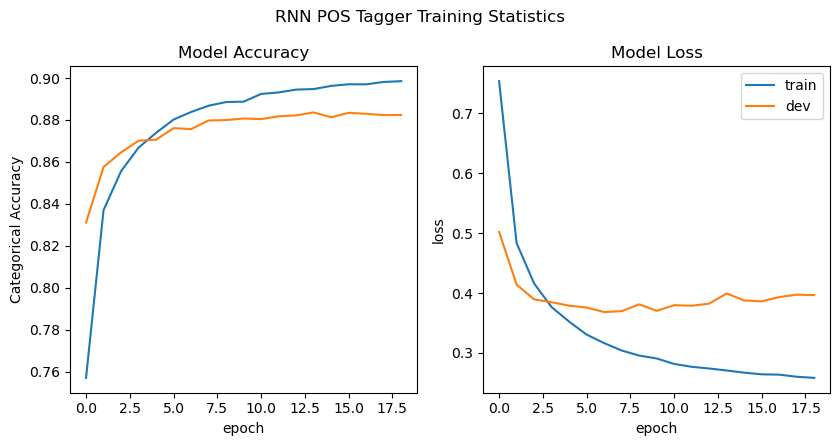

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Categorical Accuracy')
ax1.set_xlabel('epoch')

# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')

fig.suptitle("RNN POS Tagger Training Statistics")
fig.set_size_inches(8.5, 4.5)

plt.legend(['train', 'dev'], loc='upper right')
plt.tight_layout()

tasks.util.save_plot("ex_3_fit.png", OUTPUT_DIR)
plt.show()

## Results

We will now calculate and export the results of our RNN, MLP and baseline classifiers on the training, validation and test sets. We will be using precision, recall and f1 scores as metrics. We **can not use PR-AUC scores**, since they are only defined for binary classification tasks.

In [51]:
base_res_df = tasks.util.stats_all_splits(
    base_cls,
    lambda x: np.array(x),
    x_base_train,
    x_base_valid,
    x_base_test,
    y_base_train,
    y_base_valid,
    y_base_test,
)
base_res_df["model"] = "Baseline"

In [52]:
mlp_res_df = tasks.util.stats_all_splits(
    mlp,
    lambda x: lb_mlp.inverse_transform(x),
    x_train_mlp,
    x_valid_mlp,
    x_test_mlp,
    y_train_mlp,
    y_valid_mlp,
    y_test_mlp,
)
mlp_res_df["model"] = "MLP"

313/313 [==============================] - 1s 2ms/step


In [53]:
rnn_res_df = tasks.util.stats_all_splits(
    rnn_model,
    lambda output: np.array([x.upper() for x in decode(tag_tokenizer, output)]),
    train_data,
    val_data,
    test_data,
    y_train,
    y_valid,
    y_test,
)
rnn_res_df["model"] = "RNN"

745/745 [==============================] - 20s 26ms/step


In [54]:
cnn_res_df = tasks.util.stats_all_splits(
    best_model,
    lambda output: np.array([x.upper() for x in decode(tag_tokenizer, output)]),
    train_data,
    val_data,
    test_data,
    y_train,
    y_valid,
    y_test,
)
cnn_res_df["model"] = "CNN"

745/745 [==============================] - 7s 9ms/step


In [55]:
final_df = pd.concat([base_res_df, mlp_res_df, rnn_res_df, cnn_res_df])

final_train_df = final_df[final_df.split == "training"]
final_valid_df = final_df[final_df.split == "validation"]
final_test_df = final_df[final_df.split == "test"]

final_train_df = final_train_df.drop("split", axis=1)
final_valid_df = final_valid_df.drop("split", axis=1)
final_test_df = final_test_df.drop("split", axis=1)

final_train_df = final_train_df.pivot(
    index="tag", columns="model", values=["precision", "recall", "f1"]
)

final_valid_df = final_valid_df.pivot(
    index="tag", columns="model", values=["precision", "recall", "f1"]
)

final_test_df = final_test_df.pivot(
    index="tag", columns="model", values=["precision", "recall", "f1"]
)

In [56]:
final_train_df

precision                                  recall                      \
model  Baseline       CNN       MLP       RNN  Baseline       CNN       MLP   
tag                                                                           
ADJ    1.000000  1.000000  1.000000  1.000000  0.892329  0.911156  0.922889   
ADP    1.000000  1.000000  1.000000  1.000000  0.665351  0.856136  0.917631   
ADV    1.000000  1.000000  1.000000  1.000000  0.828714  0.789595  0.847708   
AUX    1.000000  1.000000  1.000000  1.000000  0.784560  0.902479  0.966456   
CCONJ  1.000000  1.000000  1.000000  1.000000  0.992638  0.979567  0.996458   
DET    1.000000  1.000000  1.000000  1.000000  0.951195  0.977570  0.974522   
INTJ   1.000000  1.000000  1.000000  1.000000  0.860140  0.777972  0.813187   
MACRO  0.845986  0.830296  0.928997  0.862229  0.830756  0.753478  0.888791   
NOUN   1.000000  1.000000  1.000000  1.000000  0.895504  0.921672  0.941784   
NUM    1.000000  1.000000  1.000000  1.000000  0.880096  0.987743  0.969977   
PART   1.000000  1.000000  1.000000  1.000000  0.885943  0.993024  0.965015   
PRON   1.000000  1.000000  1.000000  1.000000  0.949727  0.958548  0.967547   
PROPN  1.000000  1.000000  1.000000  1.000000  0.833732  0.828417  0.825843   
PUNCT  1.000000  1.000000  1.000000  1.000000  0.988128  0.014751  0.997107   
SCONJ  1.000000  1.000000  1.000000  1.000000  0.415016  0.450209  0.662675   
SYM    1.000000  1.000000  1.000000  1.000000  0.833832  0.008982  0.896104   
VERB   1.000000  1.000000  1.000000  1.000000  0.888163  0.898225  0.904866   
X      1.000000  1.000000  1.000000  1.000000  0.577778  0.553086  0.539683   

                       f1                                
model       RNN  Baseline       CNN       MLP       RNN  
tag                                                      
ADJ    0.933017  0.943101  0.953513  0.959898  0.965348  
ADP    0.881683  0.799052  0.922493  0.957047  0.937122  
ADV    0.777489  0.906335  0.882429  0.917578  0.874817  
AUX    0.954652  0.879275  0.948740  0.982942  0.976800  
CCONJ  0.980018  0.996306  0.989678  0.998226  0.989908  
DET    0.976953  0.974987  0.988658  0.987097  0.988342  
INTJ   0.777972  0.924812  0.875123  0.896970  0.875123  
MACRO  0.762975  0.831846  0.741053  0.903628  0.750991  
NOUN   0.921908  0.944872  0.959240  0.970019  0.959367  
NUM    0.993605  0.936224  0.993834  0.984760  0.996792  
PART   0.980467  0.939523  0.996500  0.982196  0.990137  
PRON   0.923372  0.974215  0.978835  0.983506  0.960160  
PROPN  0.823634  0.909328  0.906158  0.904615  0.903288  
PUNCT  0.014663  0.994029  0.029074  0.998551  0.028902  
SCONJ  0.590198  0.586588  0.620888  0.797119  0.742295  
SYM    0.008982  0.909388  0.017804  0.945205  0.017804  
VERB   0.854179  0.940770  0.946384  0.950057  0.921355  
X      0.577778  0.732394  0.712242  0.701031  0.732394

In [57]:
def export_to_latex(
    df: pd.DataFrame, name: str, caption: str = None, index: bool = False
):
    """
    Export a pandas DataFrame to a LaTeX file.

    :param df: The DataFrame to be exported.
    :type df: pd.DataFrame

    :param name: The name of the LaTeX file (excluding the '.tex' extension).
    :type name: str

    :param col_format: A string specifying the column formatting for the LaTeX table.
    :type col_format: str

    :param caption: The caption for the LaTeX table (optional).
    :type caption: str, optional

    :return: This function does not return anything.
    """
    path = os.path.join(OUTPUT_DIR, name)
    long_col_format = "|l|" * (df.shape[1] + (1 if index else 0))

    df.to_latex(
        buf=path,
        index=index,
        formatters={"name": str.upper},
        float_format="{:.3f}".format,
        label="tab::" + name.split(".")[0],
        caption=caption,
        escape=True,
        bold_rows=True,
        encoding="utf-8",
        column_format=long_col_format,
    )
    print(f"Dataframe exported to {path}")

In [58]:
export_to_latex(
    final_train_df, "ex_3_train.tex", "Results on the training dataset.", index=True
)

export_to_latex(
    final_valid_df,
    "ex_3_valid.tex",
    "Results on the validation dataset.",
    index=True,
)

export_to_latex(
    final_test_df, "ex_3_test.tex", "Results on the test dataset.", index=True
)

Dataframe exported to output/ex_3_train.tex
Dataframe exported to output/ex_3_valid.tex
Dataframe exported to output/ex_3_test.tex
